In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install surprise

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from surprise import accuracy

# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

from collections import defaultdict

# for implementing cross validation
from surprise.model_selection import KFold

In [5]:
#col_names = ['user_id', 'item_id', 'rating', 'timestamp']
rating = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv', names=['user_id', 'item_id', 'rating', 'timestamp'])
rating = rating.drop('timestamp', axis=1)

In [6]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   item_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [7]:
rating.head ()

,user_id,item_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


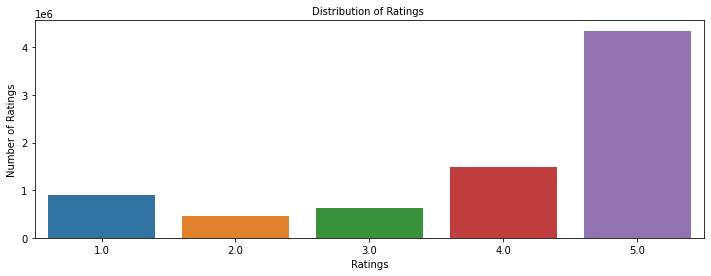

In [8]:
plt.figure(figsize = (12, 4))
sns.countplot(x="rating", data=rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

In [9]:
pip install nbconvert

In [10]:
df=rating.copy()

In [11]:
# Get the column containing the users
users = rating.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1  


In [12]:
ratings_count

{'AKM1MP6P0OYPR': 2,
 'A2CX7LUOHB2NDG': 4,
 'A2NWSAGRHCP8N5': 1,
 'A2WNBOD3WNDNKT': 1,
 'A1GI0U4ZRJA8WN': 1,
 'A1QGNMC6O1VW39': 2,
 'A3J3BRHTDRFJ2G': 19,
 'A2TY0BTJOTENPG': 4,
 'A34ATBPOK6HCHY': 3,
 'A89DO69P0XZ27': 1,
 'AZYNQZ94U6VDB': 5,
 'A1DA3W4GTFXP6O': 1,
 'A29LPQQDG7LD5J': 1,
 'AO94DHGC771SJ': 9,
 'AMO214LNFCEI4': 9,
 'A28B1G1MSJ6OO1': 2,
 'A3N7T0DY83Y4IG': 14,
 'A1H8PY3QHMQQA0': 27,
 'A2CPBQ5W4OGBX': 2,
 'A265MKAR2WEH3Y': 2,
 'A37K02NKUIT68K': 3,
 'A2AW1SSVUIYV9Y': 1,
 'A2AEHUKOV014BP': 1,
 'AMLFNXUIEMN4T': 1,
 'A2O8FIJR9EBU56': 1,
 'A3IQGFB959IR4P': 1,
 'AYTBGUX49LF3W': 1,
 'A24QFSUU00IZ05': 1,
 'A1NG5X8VYZWX0Q': 1,
 'A1E4WG8HRWWK4R': 3,
 'A2AOEW5UGXFOOQ': 1,
 'A2XSWV6AQI90BR': 2,
 'AR84FMFYCQCWF': 1,
 'A19TBA1WARJS55': 1,
 'A3C5SMBSKKWNPT': 1,
 'A24EV6RXELQZ63': 6,
 'A3T6ZQONABIJSG': 2,
 'A132P6YSJSI5G2': 1,
 'A1NQPG5IJ43HJI': 6,
 'A2WOJCFAWI8VS8': 2,
 'A22FB2WSZSXSHH': 1,
 'AZQZ3STMCBG5H': 1,
 'A2EGPA22UHMQXL': 1,
 'AC57CU3TF6ZMJ': 1,
 'A2YX0Z6RHA8Y2H': 1,
 'A38T51B7J6QVD9':

In [13]:
# We want our users to have at least 50 ratings to be considred
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
rating = rating.loc[~rating.user_id.isin(remove_users)]

In [14]:
rating

,user_id,item_id,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
...,...,...,...
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
7824427,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0
7824436,A3AYSYSLHU26U9,B00LI4ZZO8,4.0
7824438,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0


In [15]:
remove_users

['AKM1MP6P0OYPR',
 'A2CX7LUOHB2NDG',
 'A2NWSAGRHCP8N5',
 'A2WNBOD3WNDNKT',
 'A1GI0U4ZRJA8WN',
 'A1QGNMC6O1VW39',
 'A3J3BRHTDRFJ2G',
 'A2TY0BTJOTENPG',
 'A34ATBPOK6HCHY',
 'A89DO69P0XZ27',
 'AZYNQZ94U6VDB',
 'A1DA3W4GTFXP6O',
 'A29LPQQDG7LD5J',
 'AO94DHGC771SJ',
 'AMO214LNFCEI4',
 'A28B1G1MSJ6OO1',
 'A3N7T0DY83Y4IG',
 'A1H8PY3QHMQQA0',
 'A2CPBQ5W4OGBX',
 'A265MKAR2WEH3Y',
 'A37K02NKUIT68K',
 'A2AW1SSVUIYV9Y',
 'A2AEHUKOV014BP',
 'AMLFNXUIEMN4T',
 'A2O8FIJR9EBU56',
 'A3IQGFB959IR4P',
 'AYTBGUX49LF3W',
 'A24QFSUU00IZ05',
 'A1NG5X8VYZWX0Q',
 'A1E4WG8HRWWK4R',
 'A2AOEW5UGXFOOQ',
 'A2XSWV6AQI90BR',
 'AR84FMFYCQCWF',
 'A19TBA1WARJS55',
 'A3C5SMBSKKWNPT',
 'A24EV6RXELQZ63',
 'A3T6ZQONABIJSG',
 'A132P6YSJSI5G2',
 'A1NQPG5IJ43HJI',
 'A2WOJCFAWI8VS8',
 'A22FB2WSZSXSHH',
 'AZQZ3STMCBG5H',
 'A2EGPA22UHMQXL',
 'AC57CU3TF6ZMJ',
 'A2YX0Z6RHA8Y2H',
 'A38T51B7J6QVD9',
 'A1HOSS7PNC1LMU',
 'A9HI77BE35VYE',
 'A3HFUWKSPF5QEH',
 'A38ETMHM9ATSF0',
 'A34O6MND17VDDH',
 'A3JSAGWSLY5044',
 'A3B12X05JZKM94',
 'AKZ

In [16]:
rating.shape

(125871, 3)

In [17]:
# Get the column containing the users
users = rating.item_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    

In [18]:
rating['user_id'].nunique()

1540

In [19]:
rating.head()

,user_id,item_id,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [20]:
ratings_count

{'0594451647': 1,
 '0594481813': 1,
 '0970407998': 2,
 '0972683275': 4,
 '1400501466': 6,
 '1400501520': 1,
 '1400501776': 2,
 '1400532620': 2,
 '1400532655': 6,
 '140053271X': 2,
 '1400599997': 5,
 '1400698987': 2,
 '1400699169': 1,
 '1685560148': 1,
 '3744295508': 1,
 '7562434166': 1,
 '787988002X': 2,
 '8862935307': 1,
 '8862936826': 1,
 '9043413585': 2,
 '9573212900': 1,
 '9573212919': 1,
 '9575871979': 2,
 '9800359788': 1,
 '9981719005': 1,
 '9981734241': 1,
 '9981739588': 1,
 '9983722615': 1,
 '998376234X': 1,
 '9983891212': 8,
 '9984922626': 1,
 '9984984362': 1,
 '9985511298': 1,
 '9985511476': 1,
 '9985525264': 1,
 '9985696999': 1,
 '9989360391': 1,
 'B000000O48': 1,
 'B000001OKH': 1,
 'B000001OL6': 1,
 'B000001OM4': 2,
 'B000001OM5': 2,
 'B000001OMI': 1,
 'B000001OMN': 1,
 'B000001OMZ': 1,
 'B000001ON0': 2,
 'B000001ON6': 2,
 'B000006OQ8': 1,
 'B00000DM9M': 1,
 'B00000DM9W': 5,
 'B00000IGBF': 1,
 'B00000J03B': 1,
 'B00000J040': 1,
 'B00000J05A': 1,
 'B00000J061': 4,
 'B00000J0

In [21]:
rating['user_id'].value_counts()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A11KQADBYE0UZL     50
AOQLV2LSI9B2W      50
A11R5VW7IM6ISQ     50
A1LA4K5JF78BER     50
AMO1MLSIJSQOF      50
Name: user_id, Length: 1540, dtype: int64

In [22]:
rating['item_id'].nunique()

48190

In [23]:
rating['item_id'].value_counts()

B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B00BWHILC4      1
B0010BI230      1
B001EUPMWG      1
B000WTMAP2      1
B0014E10AU      1
Name: item_id, Length: 48190, dtype: int64

In [24]:
rating.groupby(['user_id', 'item_id']).count()

rating
user_id        item_id           
A100UD67AHFODS B00004Z5M1       1
               B00005T3X7       1
               B000069EUW       1
               B000069JWX       1
               B0000AR0I4       1
...                           ...
AZOK5STV85FBJ  B00AANMVNQ       1
               B00B25P27S       1
               B00BF6HVG4       1
               B00FB2XNCE       1
               B00JG5VV9O       1

[125871 rows x 1 columns]

In [25]:
rating.groupby(['user_id', 'item_id']).count()['rating'].sum()

125871

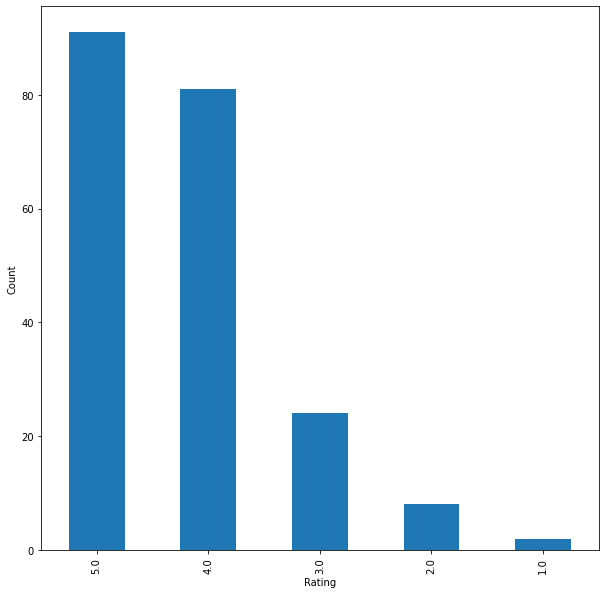

In [26]:
#Plotting distributions of ratings for 74 interactions with itemid B0088CJT4U
plt.figure(figsize=(10,10))

rating[rating['item_id'] == 'B0088CJT4U']['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

In [27]:
rating.value_counts()

user_id         item_id     rating
AZOK5STV85FBJ   B00JG5VV9O  4.0       1
A296QED1MV1V0J  B001S2PPT0  4.0       1
                B002EUCU3O  5.0       1
                B002MUYOLW  1.0       1
                B002O3KVSC  5.0       1
                                     ..
A3L1VJMHFWONCB  B003TDIEXU  2.0       1
                B003VAK16O  4.0       1
                B003VYH1UE  5.0       1
                B003XRNRB6  5.0       1
A100UD67AHFODS  B00004Z5M1  5.0       1
Length: 125871, dtype: int64

In [28]:
rating['item_id'] == 'B0088CJT4U'

94         False
118        False
177        False
178        False
492        False
           ...  
7824426    False
7824427    False
7824436    False
7824438    False
7824444    False
Name: item_id, Length: 125871, dtype: bool

In [29]:
rating[rating['item_id'] == 'B0088CJT4U']

,user_id,item_id,rating
6104981,A3EZEP0FX5BC1P,B0088CJT4U,4.0
6104982,AQCJWSMSURQI2,B0088CJT4U,4.0
6104986,A1J5HIF41ENSMZ,B0088CJT4U,3.0
6104994,A19UTUEBWKIZFT,B0088CJT4U,5.0
6105009,AV8MDYLHHTUOY,B0088CJT4U,4.0
...,...,...,...
6106352,A10H24TDLK2VDP,B0088CJT4U,4.0
6106356,A1QOK9LU90ACF7,B0088CJT4U,5.0
6106357,A20L63B48RPSOH,B0088CJT4U,4.0
6106374,A357B3PUHSVQA,B0088CJT4U,4.0


In [30]:
rating[rating['item_id'] == 'B0088CJT4U']['rating']

6104981    4.0
6104982    4.0
6104986    3.0
6104994    5.0
6105009    4.0
          ... 
6106352    4.0
6106356    5.0
6106357    4.0
6106374    4.0
6106381    5.0
Name: rating, Length: 206, dtype: float64

In [31]:
  rating[rating['item_id'] == 'B0088CJT4U']['rating'].value_counts()

5.0    91
4.0    81
3.0    24
2.0     8
1.0     2
Name: rating, dtype: int64

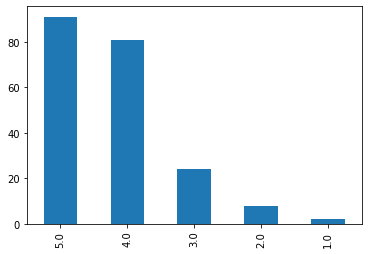

In [32]:
  rating[rating['item_id'] == 'B0088CJT4U']['rating'].value_counts().plot (kind= 'bar')

(array([2., 0., 1., 0., 0., 0., 0., 0., 1., 1.]),
 array([ 2. , 10.9, 19.8, 28.7, 37.6, 46.5, 55.4, 64.3, 73.2, 82.1, 91. ]),
 <a list of 10 Patch objects>)

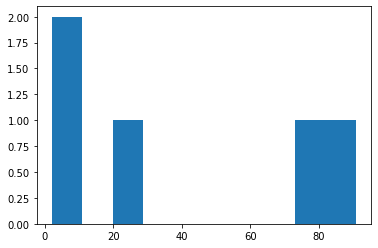

In [33]:
 plt.hist(rating[rating['item_id'] == 'B0088CJT4U']['rating'].value_counts())

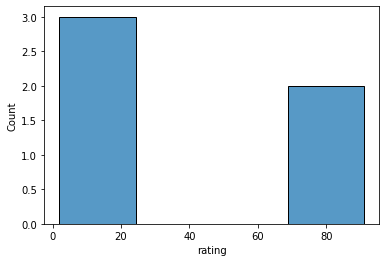

In [34]:
sns.histplot(rating[rating['item_id'] == 'B0088CJT4U']['rating'].value_counts())

In [35]:
count_interactions = rating.groupby('user_id').count()['item_id']
count_interactions

user_id
A100UD67AHFODS    116
A100WO06OQR8BQ    132
A105S56ODHGJEK     68
A105TOJ6LTVMBG     71
A10AFVU66A79Y1     65
                 ... 
AZBXKUH4AIW3X      53
AZCE11PSTCH1L      60
AZMY6E8B52L2T     189
AZNUHQSHZHSUE      54
AZOK5STV85FBJ      54
Name: item_id, Length: 1540, dtype: int64

In [36]:
#Calculating average ratings
average_rating = rating.groupby('item_id').mean()['rating']

#Calculating the count of ratings
count_rating = rating.groupby('item_id').count()['rating']

#Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [37]:
final_rating.head()

,avg_rating,rating_count
item_id,,
0594451647,5.000000,1
0594481813,3.000000,1
0970407998,2.500000,2
0972683275,4.750000,4
1400501466,3.333333,6


In [38]:
def top_n_items(data, n, min_interaction=30):
    
    #Finding items with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

In [39]:
top_n_items (final_rating, 5, 50)

Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='item_id')

In [40]:
np.array(top_n_items (final_rating, 5, 50))

array(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU',
       'B000QUUFRW'], dtype=object)

In [41]:
list(top_n_items (final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

In [42]:
# while True:pass

KeyboardInterrupt: ignored

In [44]:
from sklearn.preprocessing import LabelEncoder
df=rating[['user_id','item_id']].apply(LabelEncoder().fit_transform)
df['rating']=rating['rating']
df.head()

,user_id,item_id,rating
94,942,0,5.0
118,1461,1,3.0
177,850,2,1.0
178,82,2,4.0
492,950,3,5.0


In [45]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.7, random_state=42)

In [46]:
sim_options = {'name': 'cosine',
               'user_based': True}

algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset, and predict ratings for the testset
algo_knn_user.fit(trainset)
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.1005


1.1004694751706667

In [47]:
algo_knn_user.predict(0,3906, r_ui=4, verbose=True)

user: 0          item: 3906       r_ui = 4.00   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid=0, iid=3906, r_ui=4, est=4.262943248324992, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [48]:
algo_knn_user.predict(0,100, verbose=True)

user: 0          item: 100        r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=0, iid=100, r_ui=None, est=4.262943248324992, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [49]:
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# fitting the data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.053053302082761
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [50]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,1.061356,1.052176,1.055401,1.056311,0.003803,18,0.805416,0.799246,0.801858,0.802173,0.002529,1,0.196184,0.021622,1.418955,0.014341,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,1.059887,1.050602,1.053328,1.054606,0.003897,9,0.806962,0.800818,0.803013,0.803598,0.002542,6,0.682278,0.010009,1.402809,0.007781,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,1.058394,1.049104,1.052677,1.053391,0.003826,6,0.815319,0.810388,0.812185,0.812631,0.002038,7,0.199470,0.039850,2.006625,0.446991,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,1.058301,1.048861,1.052534,1.053232,0.003886,3,0.816974,0.811736,0.813730,0.814147,0.002159,12,0.677077,0.007811,1.381328,0.029988,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,1.061268,1.051200,1.055657,1.056042,0.004119,12,0.823061,0.817220,0.819806,0.820029,0.002390,13,0.169613,0.004112,1.400666,0.006292,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


In [51]:
gs

In [52]:
gs.head()

AttributeError: ignored

In [1]:
gs.cv_results

NameError: ignored

In [ ]:
# using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6,Verbose=False)

# training the algorithm on the trainset
similarity_algo_optimized.fit(trainset)

# predicting ratings for the testset
predictions = similarity_algo_optimized.test(testset)

# computing RMSE on testset
accuracy.rmse(predictions)

In [ ]:
similarity_algo_optimized.predict(0,3906, r_ui=4, verbose=True)

In [ ]:
similarity_algo_optimized.predict(0,100, verbose=True)

In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    
    # creating an empty list to store the recommended item ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='item_id', values='rating')
    
    # extracting those item ids which the user_id has not interacted yet
    non_interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the item id which user_id has not interacted yet
    for item_id in non_interacted_items:
        
        # predicting the ratings for those non interacted item ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating items for this user

In [ ]:
recommendations = get_recommendations(df, 4, 5, similarity_algo_optimized)

In [ ]:
recommendations

In [ ]:
#definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

#defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

#predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

In [2]:
algo_knn_item.predict(0, 3096, r_ui=4, verbose=True)

NameError: ignored

In [3]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30], 'min_k': [3],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# fitting the data
grid_obj.fit(data)

# best RMSE score
print(grid_obj.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

NameError: ignored

In [4]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

NameError: ignored

In [ ]:
}